<a href="https://colab.research.google.com/github/sm1899/Ml-algos-from-Scratch/blob/main/encoder-decoder/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
size =(128,128)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_image = '/content/drive/MyDrive/ISIC 2016/train'
train_mask = '/content/drive/MyDrive/ISIC 2016/train_masks'
test_image = '/content/drive/MyDrive/ISIC 2016/test'
test_mask = '/content/drive/MyDrive/ISIC 2016/test_masks'

train_image_paths = sorted([os.path.join(train_image, fname)
                      for fname in os.listdir(train_image)
                      if fname.endswith(".jpg")])
train_mask_paths = sorted([os.path.join(train_mask, fname)
                    for fname in os.listdir(train_mask)
                    if fname.endswith(".png")])

test_image_paths = sorted([os.path.join(test_image, fname)
                      for fname in os.listdir(test_image)
                      if fname.endswith(".jpg")])
test_mask_paths = sorted([os.path.join(test_mask, fname)
                    for fname in os.listdir(test_mask)
                    if fname.endswith(".png")])

print(len(train_image_paths),len(train_mask_paths),len(test_image_paths),len(test_mask_paths))


# splitting the train data in 90 : 10 for validation set


image_paths_train, image_paths_val, mask_paths_train, mask_paths_val = train_test_split(train_image_paths, train_mask_paths, test_size= .1 , random_state= 42)


900 900 379 379


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)


    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        mask_name = self.mask_paths[idx]

        img = Image.open(img_name)
        mask = Image.open(mask_name)

        img = np.array(img)
        mask = np.array(mask)
        mask[mask==255.0] = 1.0

        if self.transform:
            augmentation = self.transform(image=img, mask=mask)
            img = augmentation["image"]
            mask = augmentation["mask"]
            mask = torch.unsqueeze(mask,0)
        return img,mask

In [ ]:
train_transform = A.Compose([A.Resize(size[0],size[1]),
                             A.Rotate(limit=15,p=0.1),
                             A.HorizontalFlip(p=0.5),
                             A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255),
                             ToTensorV2()])

val_transform = A.Compose([A.Resize(size[0],size[1]),
                           A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255),
                           ToTensorV2()])

In [ ]:
train_dataset =  CustomDataset(image_paths_train, mask_paths_train, transform = train_transform)
val_dataset = CustomDataset(image_paths_val, mask_paths_val, transform = val_transform)
test_dataset = CustomDataset(test_image_paths, test_mask_paths, transform = val_transform)

In [ ]:
print("Train Dataset Length:", len(train_dataset))
print("Test Dataset Length:", len(test_dataset))
print("Validation Dataset Length:", len(val_dataset))


Train Dataset Length: 810
Test Dataset Length: 379
Validation Dataset Length: 90


In [ ]:
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
test_loader = DataLoader(test_dataset,batch_size=1,shuffle=False)

In [ ]:
batch_demo = next(iter(val_loader))
batch_demo[0].shape

torch.Size([32, 3, 128, 128])

In [ ]:
batch_demo[1].shape

torch.Size([32, 1, 128, 128])

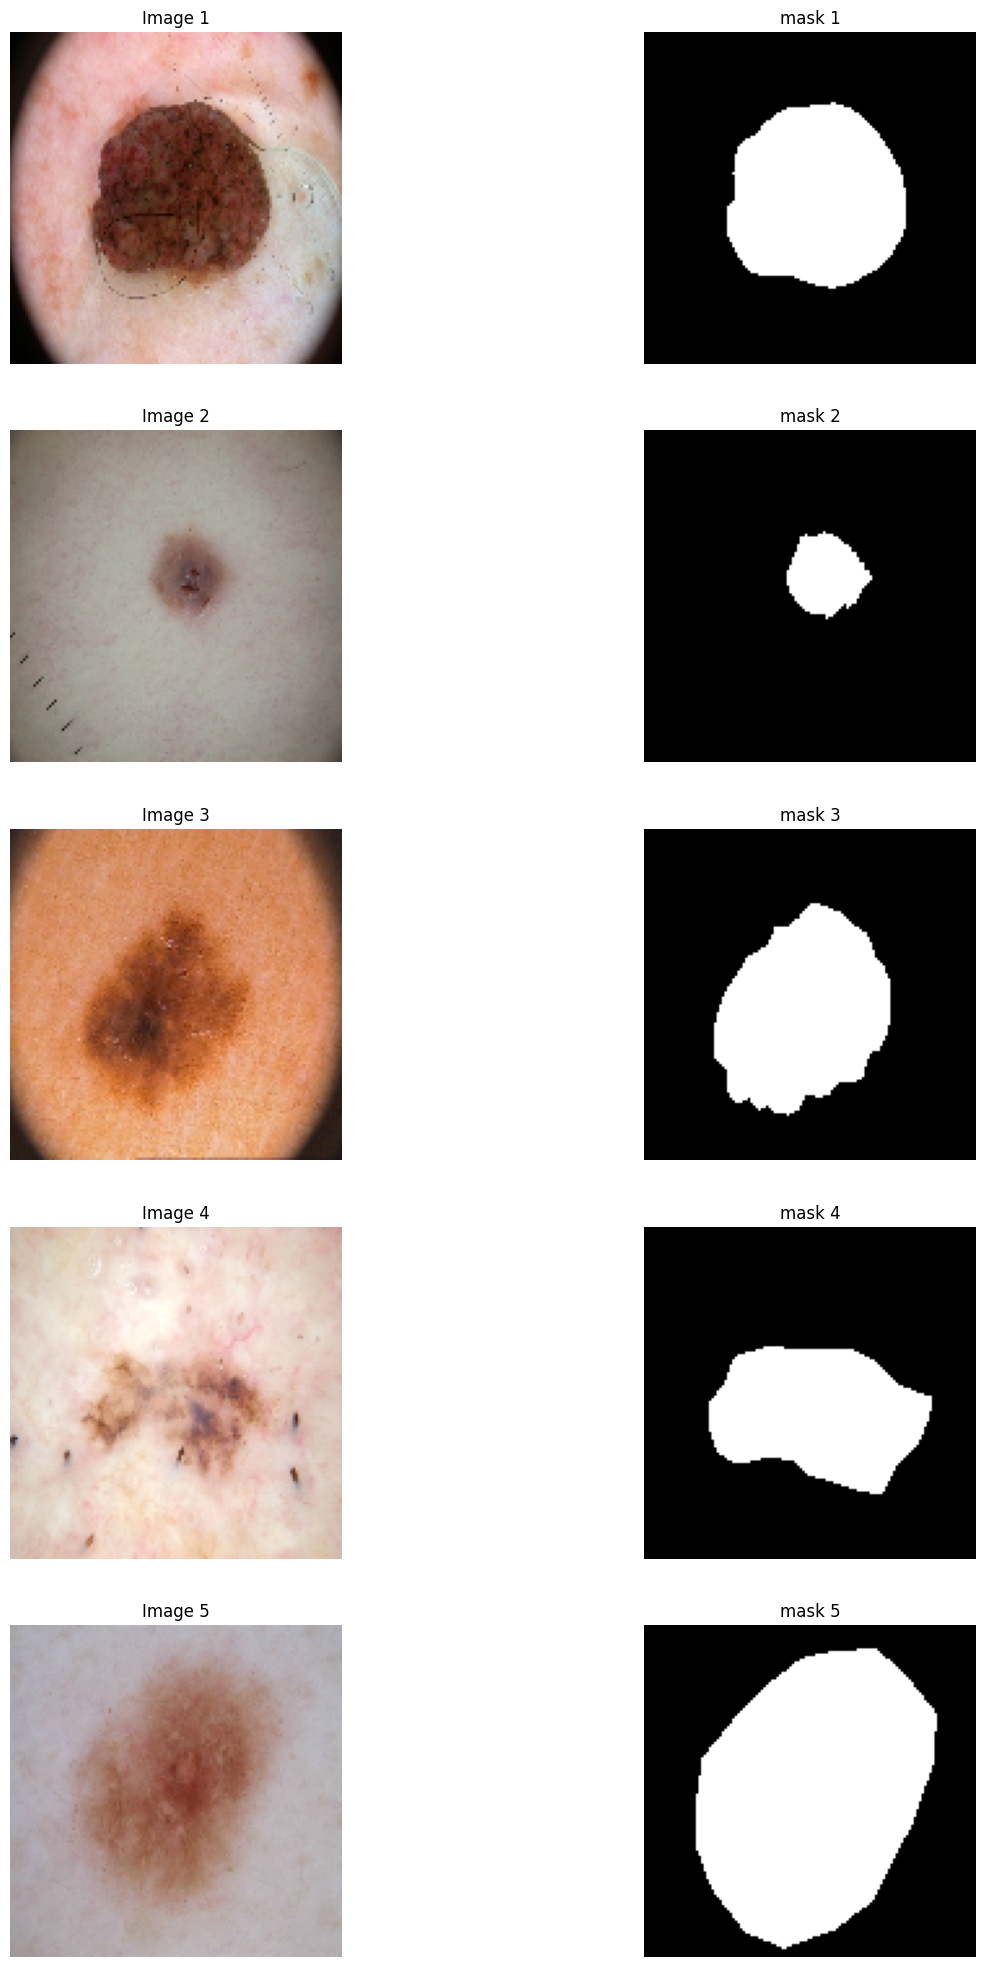

In [ ]:
images, mask = batch_demo


num_images = min(len(images), 5)  # Display up to 5 images


plt.figure(figsize=(15, 5 * num_images))
for i in range(num_images):
    plt.subplot(num_images, 2, 2 * i + 1)
    plt.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
    plt.title(f'Image {i + 1}')
    plt.axis('off')

    plt.subplot(num_images, 2, 2 * i + 2)
    plt.imshow(np.transpose(mask[i].numpy(), (1, 2, 0)).mean(axis=2), cmap='gray')
    plt.title(f'mask {i + 1}')
    plt.axis('off')

plt.show()

In [ ]:
def dice_loss(prediction, target):
    smooth = 1e-6
    intersection = torch.sum(prediction * target)
    dice = (2. * intersection + smooth) / (torch.sum(prediction) + torch.sum(target) + smooth)
    return 1 - dice

def iou_loss(prediction, target):
    intersection = torch.logical_and(prediction, target).sum()
    union = torch.logical_or(prediction, target).sum()
    iou = 1 - (intersection / union)
    return iou

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torchvision.models import mobilenet_v2



class CustomDecoder(nn.Module):
    def __init__(self, num_classes=1):
        super(CustomDecoder, self).__init__()
        self.num_classes = num_classes

        # Define layers for upsampling
        self.upconv1 = nn.ConvTranspose2d(1280, 512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upconv2 = nn.ConvTranspose2d(528, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upconv3 = nn.ConvTranspose2d(280, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upconv4 = nn.ConvTranspose2d(160, 64, kernel_size=3, stride=2, padding=1, output_padding=1)

        # Additional layers for combining features from multiple encoder layers
        self.combined_conv = nn.Conv2d(160, 64, kernel_size=1)

        # Final convolutional layer for segmentation
        self.final_conv = nn.Conv2d(64, num_classes , kernel_size=1)

    def forward(self, x, skip_connections):
        # Upsample and concatenate features from encoder layers
        x = self.upconv1(x)
        skip_connections[0] = F.interpolate(skip_connections[0], size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip_connections[0]], dim=1)

        x = self.upconv2(x)
        skip_connections[1] = F.interpolate(skip_connections[1], size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip_connections[1]], dim=1)

        x = self.upconv3(x)
        skip_connections[2] = F.interpolate(skip_connections[2], size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip_connections[2]], dim=1)

        x = self.upconv4(x)
        skip_connections[3] = F.interpolate(skip_connections[3], size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip_connections[3]], dim=1)


        x = F.interpolate(x, size=(128, 128), mode='bilinear', align_corners=False)

        # Additional convolution for combining features
        x = self.combined_conv(x)

        # Final convolution for segmentation
        x = self.final_conv(x)

        return torch.sigmoid(x)


class MobileNetEncoder(nn.Module):
    def __init__(self, freeze_mobile_net=True):
        super(MobileNetEncoder, self).__init__()
        mobilenet = models.mobilenet_v2(pretrained=True)
        self.features = mobilenet.features

        # Freeze MobileNet layers if specified
        if freeze_mobile_net:
            for param in self.features.parameters():
                param.requires_grad = False

    def forward(self, x):
        # Store features from different layers for skip connections
        skip_connections = []

        # Layer 1
        x = self.features[0:2](x)
        skip_connections.append(x)

        # Layer 2
        x = self.features[2:4](x)
        skip_connections.append(x)

        # Layer 3
        x = self.features[4:7](x)
        skip_connections.append(x)

        # Layer 4
        x = self.features[7:14](x)
        skip_connections.append(x)

        # Layer 5
        x = self.features[14:](x)

        return x, skip_connections


class MobileNetEncoderDecoder(nn.Module):
    def __init__(self, num_classes=1, freeze_mobile_net=True):
        super(MobileNetEncoderDecoder, self).__init__()
        self.encoder = MobileNetEncoder(freeze_mobile_net)
        self.decoder = CustomDecoder(num_classes)

    def forward(self, x):
        # Encoder
        x, skip_connections = self.encoder(x)

        # Decoder
        x = self.decoder(x, skip_connections)

        return x


model = MobileNetEncoderDecoder().to(device)
# input tensor
input_tensor = torch.randn(1, 3,128, 128).to(device)
output_tensor = model(input_tensor)
print(output_tensor.shape)  # Example output shape
# Output: torch.Size([1, 1, 128, 128])



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 142MB/s]


torch.Size([1, 1, 128, 128])


# Experiment One

In [ ]:
model = MobileNetEncoderDecoder(freeze_mobile_net=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=.0001)
num_epochs = 25

In [ ]:
train_loss_list, valid_loss_list = [], []
train_iou_list, valid_iou_list = [], []
train_dice_list, valid_dice_list = [], []

for epoch in range(num_epochs):

    batch_loss_list = []
    batch_iou_list = []
    batch_dice_list = []

    model.train()
    for batch_idx, (image, mask) in enumerate(train_loader):
        image = image.float().to(device)
        mask = mask.float().to(device)

        mask_pred = model(image)

        # Calculate BCE Loss
        bce_loss = F.binary_cross_entropy(mask_pred, mask)

        # Calculate Dice Loss
        loss_dice = dice_loss(mask_pred, mask)

        # Calculate IoU Loss
        loss_iou = iou_loss(mask_pred > 0.5, mask > 0.5)

        # Combine BCE Loss, Dice Loss, and IoU Loss
        loss =  bce_loss + .1 * loss_dice + .1 * loss_iou

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss_list.append(loss.item())
        batch_iou_list.append(1 - loss_iou.item())  # 1 - IoU Loss to get IoU
        batch_dice_list.append(1 - loss_dice.item())  # 1 - Dice Loss to get Dice Score

    # Calculate average training loss, IoU, and Dice
    train_loss = sum(batch_loss_list) / len(batch_loss_list)
    train_iou = sum(batch_iou_list) / len(batch_iou_list)
    train_dice = sum(batch_dice_list) / len(batch_dice_list)

    # Print training metrics
    print(f'Epoch: {epoch+1:02d}/{num_epochs:02d} '
          f'| Train Loss: {train_loss:.4f} '
          f'| Train IoU: {train_iou:.4f} '
          f'| Train Dice: {train_dice:.4f}')

    # Validation
    model.eval()
    valid_loss_list_epoch = []
    valid_iou_list_epoch = []
    valid_dice_list_epoch = []

    with torch.no_grad():
        for batch_idx, (image, mask) in enumerate(val_loader):
            image = image.float().to(device)
            mask = mask.float().to(device)

            mask_pred = model(image)

            # Calculate BCE Loss
            valid_bce_loss = F.binary_cross_entropy(mask_pred, mask)

            # Calculate Dice Loss
            valid_loss_dice = dice_loss(mask_pred, mask)

            # Calculate IoU Loss
            valid_loss_iou = iou_loss(mask_pred > 0.5, mask > 0.5)

            # Combine BCE Loss, Dice Loss, and IoU Loss
            valid_loss = valid_bce_loss + .1* valid_loss_dice + .1 * valid_loss_iou

            valid_loss_list_epoch.append(valid_loss.item())
            valid_iou_list_epoch.append(1 - valid_loss_iou.item())  # 1 - IoU Loss to get IoU
            valid_dice_list_epoch.append(1 - valid_loss_dice.item())  # 1 - Dice Loss to get Dice Score

        # Calculate average validation loss, IoU, and Dice
        valid_loss_avg = sum(valid_loss_list_epoch) / len(valid_loss_list_epoch)
        valid_iou_avg = sum(valid_iou_list_epoch) / len(valid_iou_list_epoch)
        valid_dice_avg = sum(valid_dice_list_epoch) / len(valid_dice_list_epoch)

        # Print validation metrics
        print(f'| Validation Loss: {valid_loss_avg:.4f} '
              f'| Validation IoU: {valid_iou_avg:.4f} '
              f'| Validation Dice: {valid_dice_avg:.4f}')

    # Append metrics to lists
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss_avg)
    train_iou_list.append(train_iou)
    valid_iou_list.append(valid_iou_avg)
    train_dice_list.append(train_dice)
    valid_dice_list.append(valid_dice_avg)


Epoch: 01/25 | Train Loss: 0.7843 | Train IoU: 0.0372 | Train Dice: 0.3296
| Validation Loss: 0.6964 | Validation IoU: 0.1193 | Validation Dice: 0.3418
Epoch: 02/25 | Train Loss: 0.5867 | Train IoU: 0.3996 | Train Dice: 0.4558
| Validation Loss: 0.5003 | Validation IoU: 0.5176 | Validation Dice: 0.4888
Epoch: 03/25 | Train Loss: 0.4567 | Train IoU: 0.5646 | Train Dice: 0.5601
| Validation Loss: 0.4053 | Validation IoU: 0.5489 | Validation Dice: 0.5692
Epoch: 04/25 | Train Loss: 0.3749 | Train IoU: 0.6347 | Train Dice: 0.6316
| Validation Loss: 0.3438 | Validation IoU: 0.5901 | Validation Dice: 0.6368
Epoch: 05/25 | Train Loss: 0.3190 | Train IoU: 0.6891 | Train Dice: 0.6978
| Validation Loss: 0.2823 | Validation IoU: 0.6846 | Validation Dice: 0.6975
Epoch: 06/25 | Train Loss: 0.2868 | Train IoU: 0.7128 | Train Dice: 0.7287
| Validation Loss: 0.2643 | Validation IoU: 0.7138 | Validation Dice: 0.7209
Epoch: 07/25 | Train Loss: 0.2665 | Train IoU: 0.7364 | Train Dice: 0.7586
| Validation 

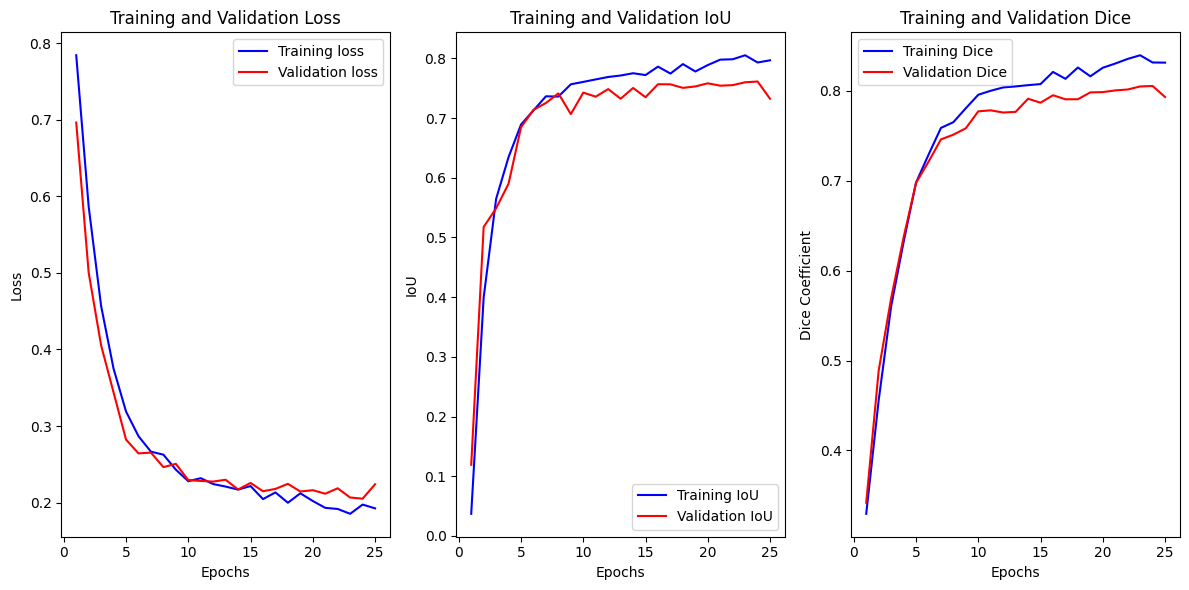

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss_list) + 1)

plt.figure(figsize=(12, 6))

# Plot Training and Validation Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss_list, 'b', label='Training loss')
plt.plot(epochs, valid_loss_list, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot IoU
plt.subplot(1, 3, 2)
plt.plot(epochs, train_iou_list, 'b', label='Training IoU')
plt.plot(epochs, valid_iou_list, 'r', label='Validation IoU')
plt.title('Training and Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

# Plot Dice
plt.subplot(1, 3, 3)
plt.plot(epochs, train_dice_list, 'b', label='Training Dice')
plt.plot(epochs, valid_dice_list, 'r', label='Validation Dice')
plt.title('Training and Validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Initialize lists to store test loss, IoU, and Dice values
test_loss_list = []
test_iou_list = []
test_dice_list = []

# Set model to evaluation mode
model.eval()

with torch.no_grad():
    for batch_idx, (image, mask) in enumerate(test_loader):
        image = image.float().to(device)
        mask = mask.float().to(device)

        mask_pred = model(image)

        # Calculate BCE Loss
        test_bce_loss = F.binary_cross_entropy(mask_pred, mask)

        # Calculate Dice Loss
        test_loss_dice = dice_loss(mask_pred, mask)

        # Calculate IoU Loss
        test_loss_iou = iou_loss(mask_pred > 0.5, mask > 0.5)

        # Combine BCE Loss, Dice Loss, and IoU Loss
        test_loss = test_bce_loss + 0.1 * test_loss_dice + 0.1 * test_loss_iou

        test_loss_list.append(test_loss.item())
        test_iou_list.append(1 - test_loss_iou.item())  # 1 - IoU Loss to get IoU
        test_dice_list.append(1 - test_loss_dice.item())  # 1 - Dice Loss to get Dice Score

# Calculate average test loss, IoU, and Dice
avg_test_loss = sum(test_loss_list) / len(test_loss_list)
avg_test_iou = sum(test_iou_list) / len(test_iou_list)
avg_test_dice = sum(test_dice_list) / len(test_dice_list)

print("Test Loss:", avg_test_loss)
print("Test IoU:", avg_test_iou)
print("Test Dice:", avg_test_dice)


Test Loss: 0.23902157123021212
Test IoU: 0.7224155338898812
Test Dice: 0.763659669887422


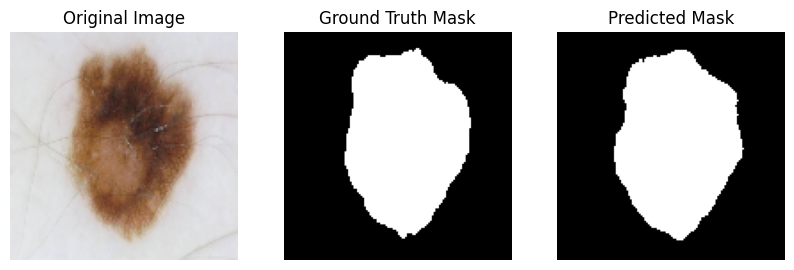

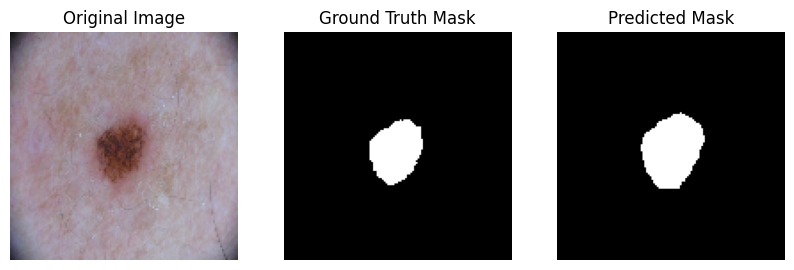

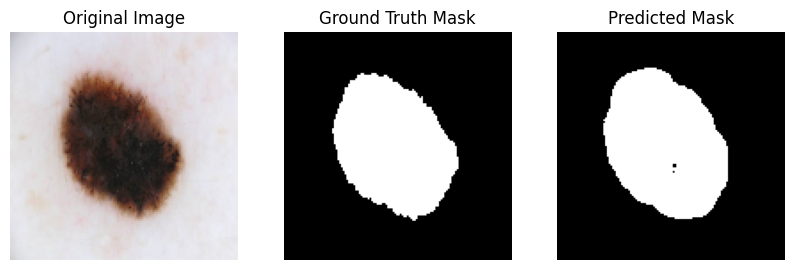

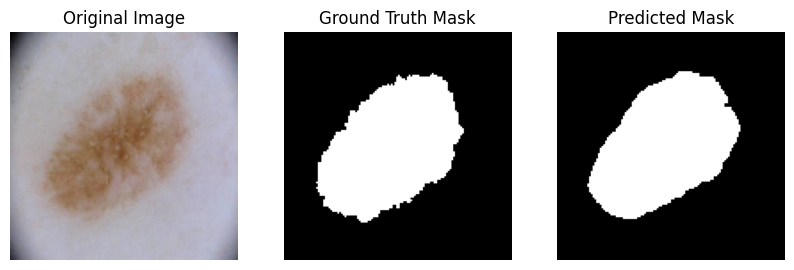

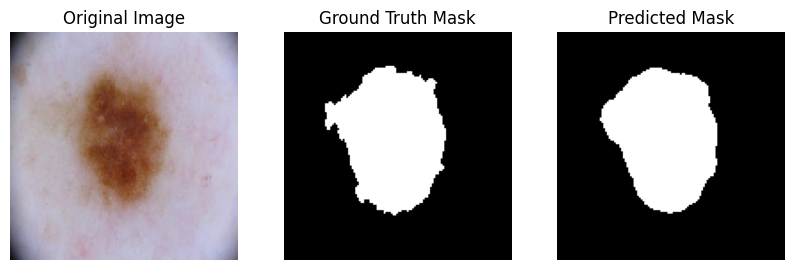

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set model to evaluation mode
model.eval()

# Get some samples from the validation set
num_samples_to_plot = 5
samples = iter(test_loader)
for _ in range(num_samples_to_plot):
    image, mask = next(samples)
    image = image.to(device)
    mask = mask.to(device)

    # Forward pass
    with torch.no_grad():
        mask_pred = model(image)

    # Convert tensors to numpy arrays
    image_np = image.cpu().numpy()[0].transpose(1, 2, 0)
    mask_np = mask.cpu().numpy()[0, 0]
    mask_pred_np = mask_pred.cpu().numpy()[0, 0]  > 0.5

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image_np)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask_np, cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(mask_pred_np, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()


# Experiment Two

In [ ]:
model = MobileNetEncoderDecoder(freeze_mobile_net=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=.0001)
num_epochs = 15

In [ ]:
train_loss_list, valid_loss_list = [], []
train_iou_list, valid_iou_list = [], []
train_dice_list, valid_dice_list = [], []

for epoch in range(num_epochs):

    batch_loss_list = []
    batch_iou_list = []
    batch_dice_list = []

    model.train()
    for batch_idx, (image, mask) in enumerate(train_loader):
        image = image.float().to(device)
        mask = mask.float().to(device)

        mask_pred = model(image)

        # Calculate BCE Loss
        bce_loss = F.binary_cross_entropy(mask_pred, mask)

        # Calculate Dice Loss
        loss_dice = dice_loss(mask_pred, mask)

        # Calculate IoU Loss
        loss_iou = iou_loss(mask_pred > 0.5, mask > 0.5)

        # Combine BCE Loss, Dice Loss, and IoU Loss
        loss =  bce_loss + .1 * loss_dice + .1 * loss_iou

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss_list.append(loss.item())
        batch_iou_list.append(1 - loss_iou.item())  # 1 - IoU Loss to get IoU
        batch_dice_list.append(1 - loss_dice.item())  # 1 - Dice Loss to get Dice Score

    # Calculate average training loss, IoU, and Dice
    train_loss = sum(batch_loss_list) / len(batch_loss_list)
    train_iou = sum(batch_iou_list) / len(batch_iou_list)
    train_dice = sum(batch_dice_list) / len(batch_dice_list)

    # Print training metrics
    print(f'Epoch: {epoch+1:02d}/{num_epochs:02d} '
          f'| Train Loss: {train_loss:.4f} '
          f'| Train IoU: {train_iou:.4f} '
          f'| Train Dice: {train_dice:.4f}')

    # Validation
    model.eval()
    valid_loss_list_epoch = []
    valid_iou_list_epoch = []
    valid_dice_list_epoch = []

    with torch.no_grad():
        for batch_idx, (image, mask) in enumerate(val_loader):
            image = image.float().to(device)
            mask = mask.float().to(device)

            mask_pred = model(image)

            # Calculate BCE Loss
            valid_bce_loss = F.binary_cross_entropy(mask_pred, mask)

            # Calculate Dice Loss
            valid_loss_dice = dice_loss(mask_pred, mask)

            # Calculate IoU Loss
            valid_loss_iou = iou_loss(mask_pred > 0.5, mask > 0.5)

            # Combine BCE Loss, Dice Loss, and IoU Loss
            valid_loss = valid_bce_loss + .1* valid_loss_dice + .1 * valid_loss_iou

            valid_loss_list_epoch.append(valid_loss.item())
            valid_iou_list_epoch.append(1 - valid_loss_iou.item())  # 1 - IoU Loss to get IoU
            valid_dice_list_epoch.append(1 - valid_loss_dice.item())  # 1 - Dice Loss to get Dice Score

        # Calculate average validation loss, IoU, and Dice
        valid_loss_avg = sum(valid_loss_list_epoch) / len(valid_loss_list_epoch)
        valid_iou_avg = sum(valid_iou_list_epoch) / len(valid_iou_list_epoch)
        valid_dice_avg = sum(valid_dice_list_epoch) / len(valid_dice_list_epoch)

        # Print validation metrics
        print(f'| Validation Loss: {valid_loss_avg:.4f} '
              f'| Validation IoU: {valid_iou_avg:.4f} '
              f'| Validation Dice: {valid_dice_avg:.4f}')

    # Append metrics to lists
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss_avg)
    train_iou_list.append(train_iou)
    valid_iou_list.append(valid_iou_avg)
    train_dice_list.append(train_dice)
    valid_dice_list.append(valid_dice_avg)


Epoch: 01/15 | Train Loss: 0.6000 | Train IoU: 0.5287 | Train Dice: 0.4535
| Validation Loss: 0.7154 | Validation IoU: 0.1450 | Validation Dice: 0.3573
Epoch: 02/15 | Train Loss: 0.2718 | Train IoU: 0.7440 | Train Dice: 0.7061
| Validation Loss: 0.2061 | Validation IoU: 0.7650 | Validation Dice: 0.7812
Epoch: 03/15 | Train Loss: 0.2027 | Train IoU: 0.7922 | Train Dice: 0.7995
| Validation Loss: 0.1654 | Validation IoU: 0.8049 | Validation Dice: 0.8259
Epoch: 04/15 | Train Loss: 0.1661 | Train IoU: 0.8188 | Train Dice: 0.8384
| Validation Loss: 0.1479 | Validation IoU: 0.8233 | Validation Dice: 0.8476
Epoch: 05/15 | Train Loss: 0.1489 | Train IoU: 0.8332 | Train Dice: 0.8617
| Validation Loss: 0.1459 | Validation IoU: 0.8265 | Validation Dice: 0.8572
Epoch: 06/15 | Train Loss: 0.1417 | Train IoU: 0.8422 | Train Dice: 0.8696
| Validation Loss: 0.1293 | Validation IoU: 0.8449 | Validation Dice: 0.8714
Epoch: 07/15 | Train Loss: 0.1400 | Train IoU: 0.8455 | Train Dice: 0.8726
| Validation 

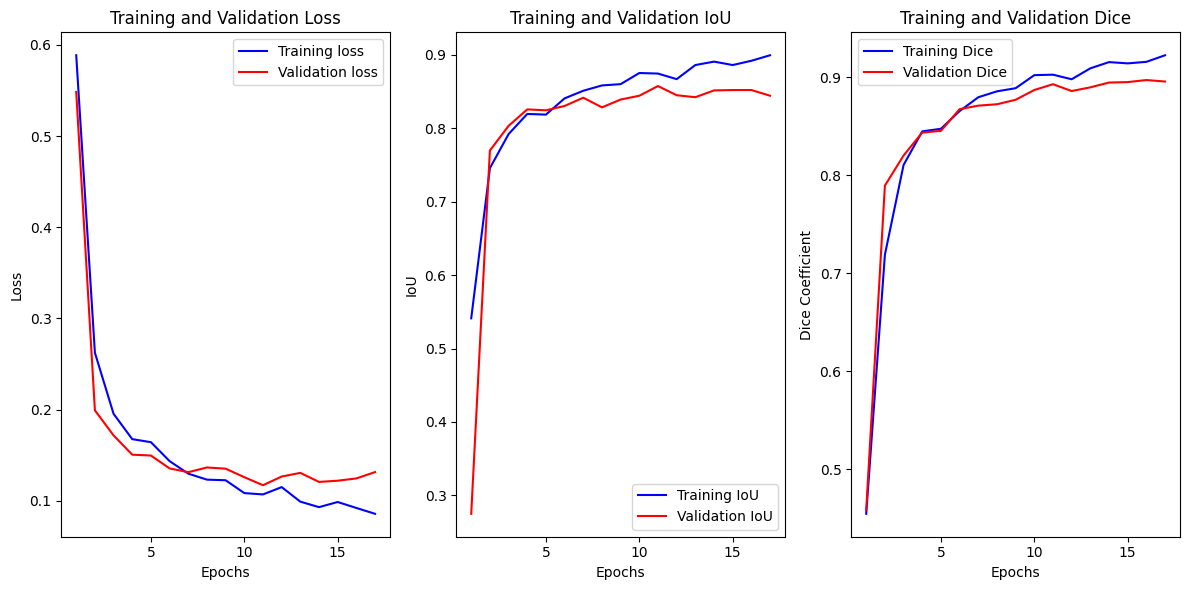

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss_list) + 1)

plt.figure(figsize=(12, 6))

# Plot Training and Validation Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss_list, 'b', label='Training loss')
plt.plot(epochs, valid_loss_list, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot IoU
plt.subplot(1, 3, 2)
plt.plot(epochs, train_iou_list, 'b', label='Training IoU')
plt.plot(epochs, valid_iou_list, 'r', label='Validation IoU')
plt.title('Training and Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

# Plot Dice
plt.subplot(1, 3, 3)
plt.plot(epochs, train_dice_list, 'b', label='Training Dice')
plt.plot(epochs, valid_dice_list, 'r', label='Validation Dice')
plt.title('Training and Validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Initialize lists to store test loss, IoU, and Dice values
test_loss_list = []
test_iou_list = []
test_dice_list = []

# Set model to evaluation mode
model.eval()

with torch.no_grad():
    for batch_idx, (image, mask) in enumerate(test_loader):
        image = image.float().to(device)
        mask = mask.float().to(device)

        mask_pred = model(image)

        # Calculate BCE Loss
        test_bce_loss = F.binary_cross_entropy(mask_pred, mask)

        # Calculate Dice Loss
        test_loss_dice = dice_loss(mask_pred, mask)

        # Calculate IoU Loss
        test_loss_iou = iou_loss(mask_pred > 0.5, mask > 0.5)

        # Combine BCE Loss, Dice Loss, and IoU Loss
        test_loss = test_bce_loss + 0.1 * test_loss_dice + 0.1 * test_loss_iou

        test_loss_list.append(test_loss.item())
        test_iou_list.append(1 - test_loss_iou.item())  # 1 - IoU Loss to get IoU
        test_dice_list.append(1 - test_loss_dice.item())  # 1 - Dice Loss to get Dice Score

# Calculate average test loss, IoU, and Dice
avg_test_loss = sum(test_loss_list) / len(test_loss_list)
avg_test_iou = sum(test_iou_list) / len(test_iou_list)
avg_test_dice = sum(test_dice_list) / len(test_dice_list)

print("Test Loss:", avg_test_loss)
print("Test IoU:", avg_test_iou)
print("Test Dice:", avg_test_dice)


Test Loss: 0.14972901176218936
Test IoU: 0.8304333526415058
Test Dice: 0.8759616474992052


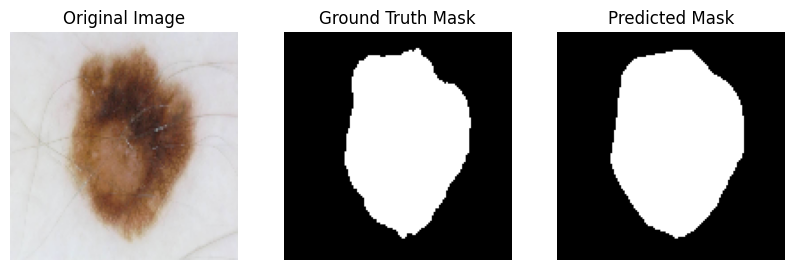

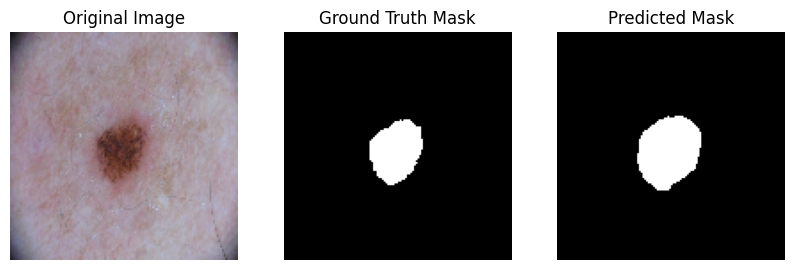

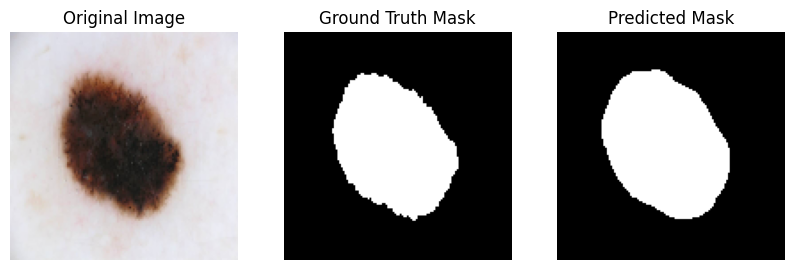

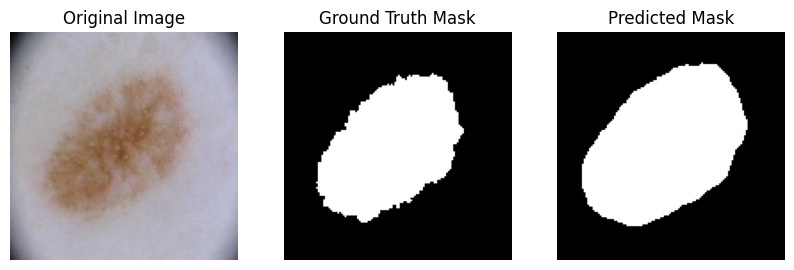

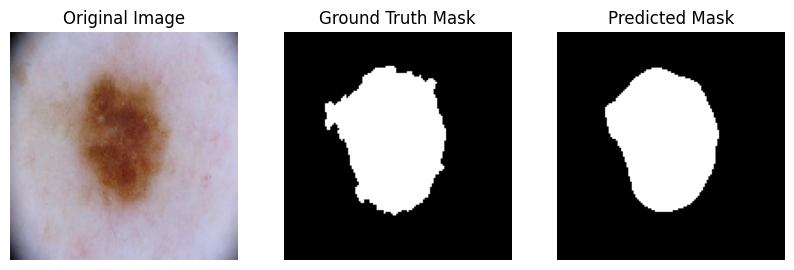

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set model to evaluation mode
model.eval()

# Get some samples from the validation set
num_samples_to_plot = 5
samples = iter(test_loader)
for _ in range(num_samples_to_plot):
    image, mask = next(samples)
    image = image.to(device)
    mask = mask.to(device)

    # Forward pass
    with torch.no_grad():
        mask_pred = model(image)

    # Convert tensors to numpy arrays
    image_np = image.cpu().numpy()[0].transpose(1, 2, 0)
    mask_np = mask.cpu().numpy()[0, 0]
    mask_pred_np = mask_pred.cpu().numpy()[0, 0]  > 0.5

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image_np)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask_np, cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(mask_pred_np, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()
